In [1]:
# Staple  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns

# Misc  
import re  
import itertools  
import os  
import joblib  
from tqdm.notebook import tqdm  
from IPython.display import HTML
import pickle
import os
import sys
import time

# NLP  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize, RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy

# Clustering  
from sklearn.decomposition import PCA, TruncatedSVD  
from sklearn.cluster import (KMeans,  AgglomerativeClustering,  
                             DBSCAN, OPTICS, cluster_optics_dbscan)  
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             silhouette_score, davies_bouldin_score)

# hyperparameter tuning
from yellowbrick.cluster.elbow import kelbow_visualizer
from kneed import KneeLocator

import sqlite3
# import plotly.express.px

# fast cluster
import fastcluster

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kbw2icqw because the default path (/home/nlim/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 08:09:53.683231: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 08:09:53.683277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-nlim
2023-02-08 08:09:53.683294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-nlim
2023-02-08 08:09:53.683413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-08 08:09:53.683453: I tensorflow/

In [2]:
def save_pkl(obj, name, prompt=False):
    """
    Save an object to a pickle file.
    
    """
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)
    if prompt:
        print('Object pickled for future use.')
    return

In [3]:
def load_pkl(obj, name):
    
    """Load an object from a pickle file."""
    
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    return joblib.load(fp)

## Importing database

In [4]:
db_path = '/mnt/processed/private/msds2023/slt5a/lab1/ssot/amazon.db'  
conn = sqlite3.connect(db_path)

In [5]:
amz_dict = {}

for date in ['2012-12', '2013-12' ,'2014-12']:
    query = f"""
        SELECT * 
        FROM amazon_main  
        WHERE review_date LIKE '%{date}%'
        """
    amz_dict.update({int(date[:4]): pd.read_sql(query, conn)})

In [6]:
amz_2013 = amz_dict[2013]

In [9]:
amz_2013.head()

,review_id,review_date,customer_id,product_id,product_title,star_rating,review_headline,review_body
0,R31NAY7F7X2IUA,2013-12-31,17854433,B002GPG6BE,RICE DREAM Classic Original Organic Rice Drink...,4,Alternative to soy milk,I like this as an alternative to soy milk but ...
1,RBZMUPRTBVIU0,2013-12-31,26602617,B009RVOTEG,Trader Joe's Pound Plus Bittersweet Chocolate ...,5,mmmm,delicious chocolate<br />it taste good and has...
2,R2I93JT332D8HF,2013-12-31,6735184,B00FSOY8IS,Doc McStuffins Birthday ~ Edible Image Cake/Cu...,5,Good product,The cake I made with this picture turned out g...
3,R21KM2RIDRI4IT,2013-12-31,49387095,B000SDKDM4,"Lavazza Whole Bean Coffee, 2.2 Pound Bag",4,Love the Lavazza,I've recently purchase an espresso machine and...
4,RW849KV3IKTJ1,2013-12-31,18845747,B003XUE9HE,Yamamotoyama Loose Genmai-Cha Green Tea with R...,3,A LITTLE MORE BITTER THAN I PREFER,"I love Genmai-chai, with the toasted rice in i..."


In [7]:
amz_2013.set_index('review_date', inplace=True)
amz_2013.head()

,review_id,customer_id,product_id,product_title,star_rating,review_headline,review_body
review_date,,,,,,,
2013-12-31,R31NAY7F7X2IUA,17854433,B002GPG6BE,RICE DREAM Classic Original Organic Rice Drink...,4,Alternative to soy milk,I like this as an alternative to soy milk but ...
2013-12-31,RBZMUPRTBVIU0,26602617,B009RVOTEG,Trader Joe's Pound Plus Bittersweet Chocolate ...,5,mmmm,delicious chocolate<br />it taste good and has...
2013-12-31,R2I93JT332D8HF,6735184,B00FSOY8IS,Doc McStuffins Birthday ~ Edible Image Cake/Cu...,5,Good product,The cake I made with this picture turned out g...
2013-12-31,R21KM2RIDRI4IT,49387095,B000SDKDM4,"Lavazza Whole Bean Coffee, 2.2 Pound Bag",4,Love the Lavazza,I've recently purchase an espresso machine and...
2013-12-31,RW849KV3IKTJ1,18845747,B003XUE9HE,Yamamotoyama Loose Genmai-Cha Green Tea with R...,3,A LITTLE MORE BITTER THAN I PREFER,"I love Genmai-chai, with the toasted rice in i..."


In [11]:
amz_2013.describe()

,customer_id
count,4.884000e+04
mean,3.023474e+07
std,1.482725e+07
min,1.011500e+04
25%,1.614675e+07
50%,3.009654e+07
75%,4.416590e+07
max,5.309641e+07


In [12]:
amz_2013.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48840 entries, 2013-12-31 to 2013-12-01
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_id        48840 non-null  object
 1   customer_id      48840 non-null  int64 
 2   product_id       48840 non-null  object
 3   product_title    48840 non-null  object
 4   star_rating      48840 non-null  object
 5   review_headline  48840 non-null  object
 6   review_body      48840 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.0+ MB


Filter dataset by date

## EDA

## Text preprocessing
- [ ] Lowercasing
- [ ] Removing punctuation, whitespaces, numbers
- [ ] Removing other specific text patterns
- [ ] Removing stop words
- [ ] Stemming or lemmatization

In [7]:
prod_titles_2013 = amz_2013[['product_title']]

In [8]:
spacy_en_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_en_model.max_length = 4000000
def clean_text_spacy(text):
    processed_text = spacy_en_model(text)
    lemmas = [w.lemma_ if w.lemma_ != '-PRON-'
    else w.lower_ for w in processed_text
    if w.is_alpha and not w.is_stop]
    return ' '.join(lemmas).lower()


In [9]:
try:
    df_lemmatized_prod_title_2013 = load_pkl('df_lemmatized_prod_title_2013.pkl')

except:
    lemmatized_prod_title_2013 = prod_titles_2013['product_title'].apply(lambda x: clean_text_spacy(x))
    df_lemmatized_prod_title_2013 = pd.DataFrame(lemmatized_prod_title_2013)
    save_pkl(df_lemmatized_prod_title_2013, 'df_lemmatized_prod_title_2013.pkl')

Vectorize titles

In [10]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2023/nlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
additional_stop_words = {'ounce', 'oz', 'lb', 'pound', 'Oz', 'Ounce'}

stops.update(additional_stop_words)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1, 1), 
                             min_df=15, max_df=0.9, 
                             token_pattern=r'[A-z]{2,}')

In [13]:
params = dict(
    stop_words=stops, 
    ngram_range=(1, 1), 
    min_df=15, max_df=0.9, 
    token_pattern=r'[A-z]{2,}'
)

In [14]:
def vectorize(corpus, model, params):
    """
    Vectorize the corpus of articles using `model`.
    """
    vectorizer = model(**params)
    sparse_corpus = vectorizer.fit_transform(corpus)
    corpus_df = pd.DataFrame.sparse.from_spmatrix(sparse_corpus, columns=vectorizer.get_feature_names_out())
    return corpus_df, sparse_corpus

In [15]:
try:
    prod_title_d_matrix_2013 = load_pkl('prod_title_d_matrix2013.pkl')

except:
    prod_title_d_matrix_2013, pd_sparse_2013 = vectorize(df_lemmatized_prod_title_2013['product_title'], TfidfVectorizer, params)
    save_pkl(prod_title_d_matrix_2013, 'prod_title_d_matrix2013.pkl')
    save_pkl(pd_sparse_2013, 'pd_sparse_2013.pkl')

In [16]:
prod_title_d_matrix_2013

,abbey,acai,acid,act,active,add,added,advent,agave,aged,...,zatarain,zealand,zero,zesty,zevia,zhena,zico,zinger,zoe,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
prod_title_d_matrix_2013.sum().sort_values(ascending=False)[:30]

pack         2250.570976
coffee       1344.673472
tea          1272.970459
cup          1189.522806
organic      1118.551538
count         986.412161
chocolate     890.907010
keurig        825.461499
bag           686.723401
free          673.378345
mix           648.873132
candy         582.678084
brewers       571.807606
box           542.971180
green         495.022640
single        474.558897
bags          465.751462
cups          455.330456
natural       451.798146
sauce         449.391072
hot           434.469840
gluten        434.337258
coconut       432.701336
variety       423.305036
original      422.229286
bean          406.318374
dark          394.272033
oil           391.245712
fruit         386.680728
bar           385.014792
dtype: float64

## KMeans Clustering

### Finding candidates for the best `k` value

In [22]:
prod_models_2013 = {}
prod_title_scores_2013 = {'sse': [], 'ch': [], 'sh': [], 'db': []}

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=1337)
    cluster_labels = kmeans.fit_predict(prod_title_d_matrix_2013)
    prod_models_2013.update({k: {
        'model': kmeans,
        'labels': cluster_labels,
    }})
    prod_title_scores_2013['sse'].append(kmeans.inertia_)
    prod_title_scores_2013['ch'].append(calinski_harabasz_score(
        prod_title_d_matrix_2013.to_numpy(),
        cluster_labels
    ))
    #prod_title_scores_2013['sh'].append(silhouette_score(
    #     prod_title_d_matrix_2013.to_numpy(), cluster_labels
    # ))
    prod_title_scores_2013['db'].append(davies_bouldin_score(
        prod_title_d_matrix_2013.to_numpy(), cluster_labels
    ))
    
save_pkl(prod_models_2013, 'prod_models_2013.pkl')
save_pkl(prod_title_scores_2013, 'prod_title_scores_2013.pkl')

  0%|          | 0/9 [00:00<?, ?it/s]

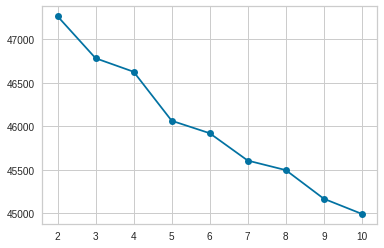

In [25]:
plt.plot(range(2, 11), prod_title_scores_2013['sse'], marker='o', label='sse')

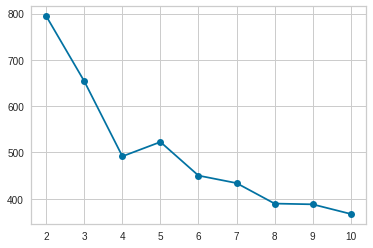

In [26]:
plt.plot(range(2, 11), prod_title_scores_2013['ch'], marker='o', label='ch')

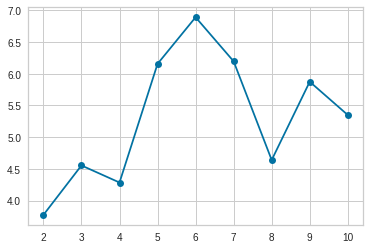

In [24]:
plt.plot(range(2, 11), prod_title_scores_2013['db'], marker='o', label='db')

In [27]:
# do not run the cells below...

In [31]:
# k-means clustering

sum_of_squared_distances = []
K = range(2, 20)

for k in K:
    start_time = time.time()
    km = KMeans(n_clusters=k, max_iter=600, n_init=10)
    km.fit(prod_title_d_matrix_2013)
    sum_of_squared_distances.append(km.inertia_)
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'elbowPlot_runtime_dec2013.pkl')

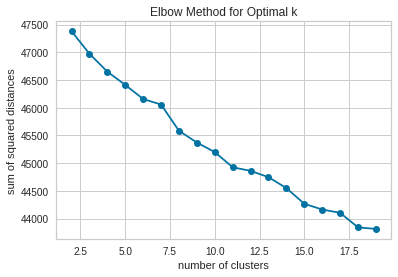

In [32]:
plt.plot(K, sum_of_squared_distances, '-o')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.savefig('img/ElbowPlot_dec2013.png')
plt.show()

Warning: the `kelbowvisualizer` might take forever...

Metric = distortion or WCSS

In [19]:
dense_2013 = prod_title_d_matrix_2013.sparse.to_dense()

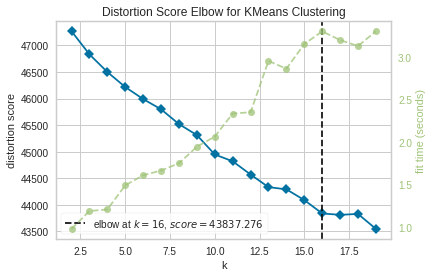

<Figure size 432x288 with 0 Axes>

In [20]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2013, k=(2, 20))
    viz.show(outpath='img/DistortionScoreElbowPlot_dec2013.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'DistortionScoreElbowPlot_runtime_dec2013.pkl')

except MemoryError():
    sys.exit()

Metric = silhouette

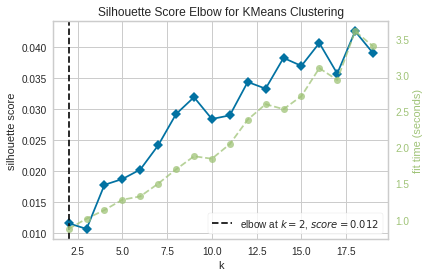

<Figure size 432x288 with 0 Axes>

In [21]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2013, k=(2, 20),
                            metric='silhouette')
    viz.show(outpath='img/SilhouetteScoreElbowPlot_dec2013.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'SilhouetteElbowPlot_runtime_dec2013')

except MemoryError():
    sys.exit()

Metric = calinski-harabasz

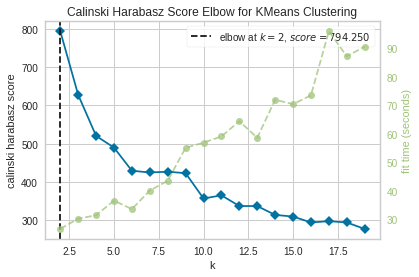

<Figure size 432x288 with 0 Axes>

In [22]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), dense_2013, k=(2, 20),
                      metric='calinski_harabasz')
    viz.show(outpath='img/CalinskiHarabaszScoreElbowPlot_dec2013.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'CalinskiHarabaszElbowPlot_runtime_dec2013')
    
except MemoryError():
    sys.exit()

The candidates for the best k-value were `9`, `7` and `2`, using the parameters `metric='distortion'`, `metric='silhouette'`, and `metric='calinski_harabasz'` respectively.

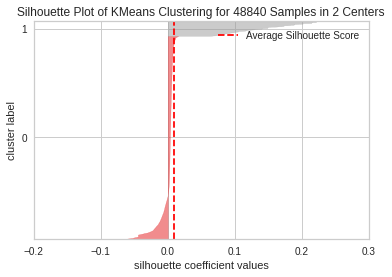

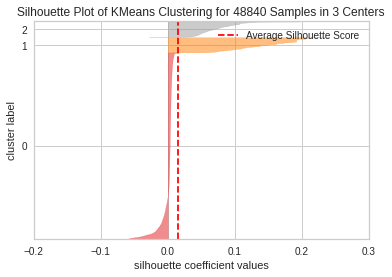

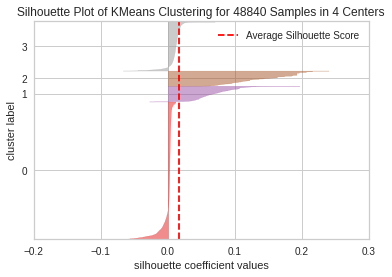

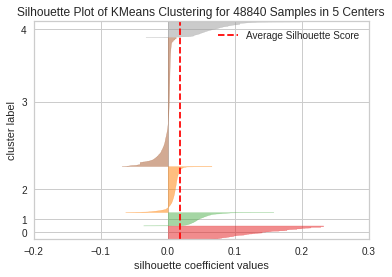

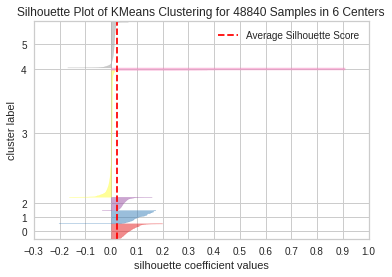

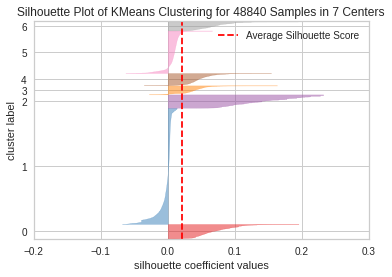

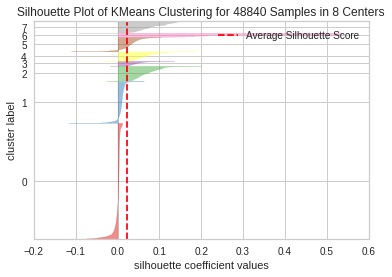

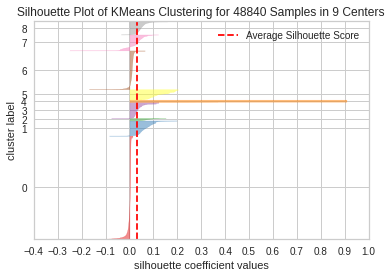

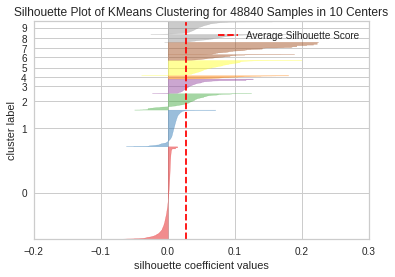

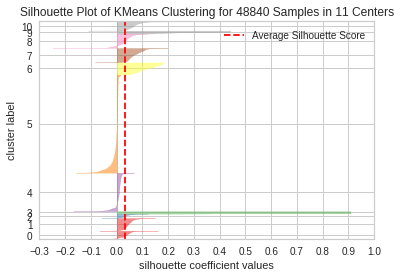

In [19]:
from yellowbrick.cluster import silhouette_visualizer

for k in range(2, 12):
    viz = silhouette_visualizer(KMeans(k, random_state=42), prod_title_d_matrix_2013)

### Transforming the dataset using TruncatedSVD

In [27]:
try:
    try:
        start_time = time.time()
        tsvd_prod_title_2013 = load_pkl('tsvd_prod_title_2013.pkl')
        end_time = time.time()
        
        save_pkl(end_time-start_time, 'TruncatedSVD_runtime_dec2013')

    except:
        tsvd = TruncatedSVD(n_components=prod_title_d_matrix_2013.shape[1])
        tsvd_prod_title_2013 = tsvd.fit(prod_title_d_matrix_2013)
        save_pkl(tsvd_prod_title_2013, 'tsvd_prod_title_2013.pkl')
        
        # sv_idx = np.argsort(tsvd_prod_title_2013.explained_variance_ratio_)[::-1]
        # transformed_2013 = tsvd_prod_title_2013[:, sv_idx]

        # pkl_save(tsvd_prod_title_2013, 'tsvd_prod_title_2013_unsorted')
        # pkl_save(transformed_2013, 'tsvd_prod_title_2013.pkl')
        # pkl_save(sv_idx, 'tsvd_sorting_index_2013')
        
        
except MemoryError():
    sys.exit()

In [28]:
explained_var= tsvd_prod_title_2013.explained_variance_ratio_
explained_var[:10]

array([0.01563878, 0.01059491, 0.01061312, 0.0099682 , 0.00916593,
       0.00883431, 0.00767095, 0.00686694, 0.00579771, 0.0054863 ])

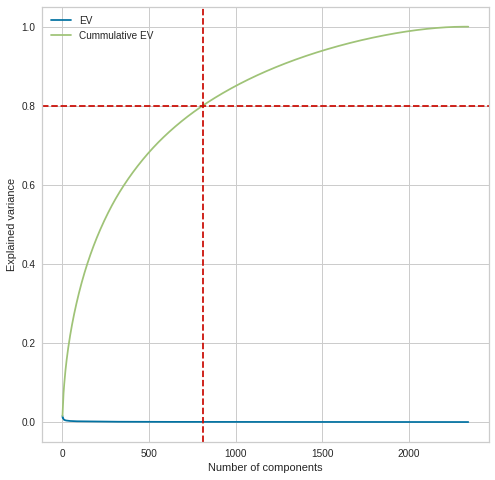

In [40]:
# Make a scree plot
plt.figure(figsize=(8, 8))
n_components = np.arange(1, len(explained_var)+1)
plt.plot(n_components, explained_var, label='EV')
plt.plot(n_components, explained_var.cumsum(), label='Cummulative EV')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
# plt.title("Explained Variance of tSVD-transformed Dataset")

# drawing horizontal and vertical lines
plt.axvline(x=814, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.legend()

plt.savefig('img/ScreePlot_prod_title_dec2013.png')
plt.show()

Based on the scree plot, if we keep the first 814 components of the SVD-transformed dataset, we would still retain 80% of the explained variance....

In [30]:
try:
    start_time = time.time()
    tsvd_prod_title_2013_n = load_pkl('tsvd_prod_title_2013_n.pkl')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'TruncatedSVD_runtime_dec2013.pkl')

except:
    n_comp = 814
    tsvd_n = TruncatedSVD(n_components=n_comp)
    tsvd_prod_title_2013_n = tsvd_n.fit_transform(prod_title_d_matrix_2013)
    save_pkl(tsvd_prod_title_2013_n, 'tsvd_prod_title_2013_n.pkl')
    
    # Sort indices
    # sv_idx_n = np.argsort(tsvd_prod_title_2013_n.explained_variance_ratio_)[::-1]
    # transformed_2013_n = tsvd_prod_title_2013_n[:, sv_idx]

    # save_pkl(tsvd_prod_title_2013_n, 'tsvd_prod_title_2013_unsorted.pkl')
    # save_pkl(transformed_2013_n, 'tsvd_prod_title_2013_n.pkl')
    # save_pkl(sv_idx_n, 'sorting_index_n_2013.pkl') 

Scatterplot of tSVD-transformed data

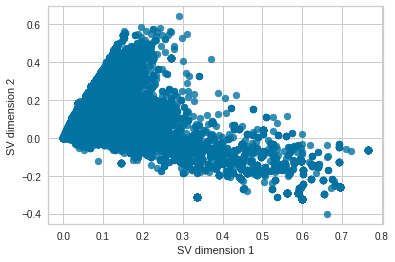

In [43]:
scatter0 = plt.scatter(tsvd_prod_title_2013_n[:, 0],
                       tsvd_prod_title_2013_n[:, 1],
                       cmap='Dark2',
                       alpha=0.8)
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
# plt.title(f'Scatterplot of tSVD-transformed Data')

plt.savefig('img/TruncSVDPlot_prod_title_dec2013.png')
plt.show();

### Scatterplot using the best `k-values` found

In [31]:
def plot_km(k, data, rs=1337):
    start_time = time.time()
    km = KMeans(k, random_state=rs)
    km.fit(data)
    save_pkl(km, f'KMeansClusterPlot_k{k}_dec2013.pkl')
    
    scatter1 = plt.scatter(tsvd_prod_title_2013_n[:, 0],
                           tsvd_prod_title_2013_n[:, 1],
                           c=km.labels_,
                           cmap='Dark2')
    save_pkl(scatter1.legend_elements(), f'KMeansClusterPlot_k{k}_legend_ele_dec2013.pkl')
    plt.legend(*scatter1.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    # plt.title(f'Clusters Found Using K-Means, k={k}')
    plt.savefig(f'img/KMeansScatterPlot_k{k}_dec2013.png');
    end_time = time.time()
    
    save_pkl(end_time-start_time, f'KMeansClusterPlot_k{k}_runtime_dec2013.pkl')
    
    return scatter1

In [25]:
best_ks_km = [16, 2]

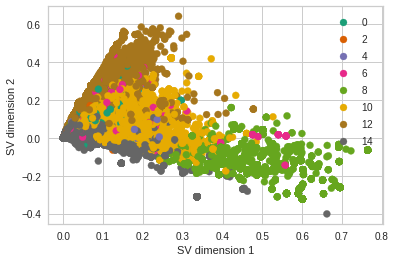

In [32]:
plot_km(k=16, data = tsvd_prod_title_2013_n)

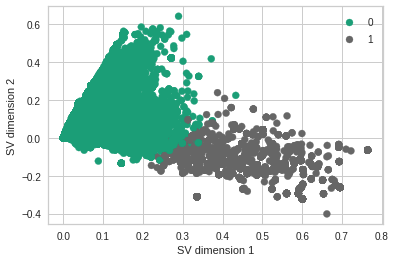

In [33]:
plot_km(k=2, data = tsvd_prod_title_2013_n)

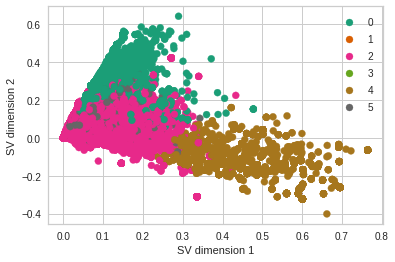

In [34]:
plot_km(k=6, data = tsvd_prod_title_2013_n)

Best number of clusters found: 7. Although the plot for two clusters was cleaner than the rest, for the use case, this is not very practical.

### Visualizing the Clusters

In [35]:
# Get clusters

true_k = 16

start_time = time.time()
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=600, n_init=10)
model.fit(prod_title_d_matrix_2013)
save_pkl(model, 'final_knn_model_2013.pkl')

# Get prediction/labels
labels = model.labels_

title_cl = pd.DataFrame(list(zip(amz_2013['product_title'], labels)), 
                       columns=['title', 'cluster'])
save_pkl(title_cl, 'prod_title_cluster_2013.pkl')
end_time = time.time()

save_pkl(end_time - start_time, 'KMeans_best_k_runtime_dec2013.pkl')

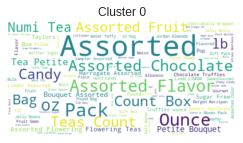

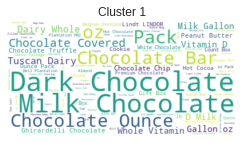

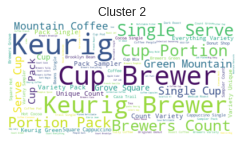

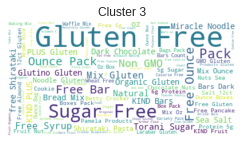

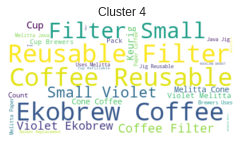

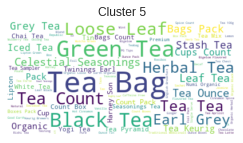

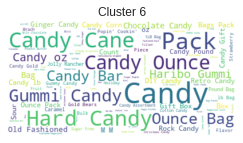

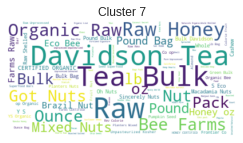

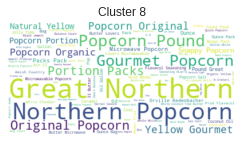

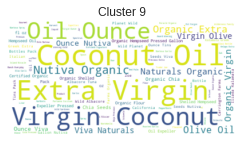

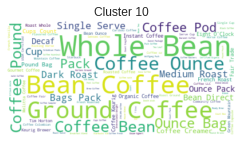

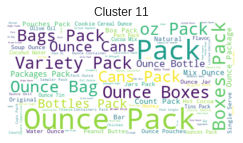

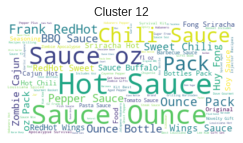

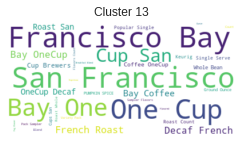

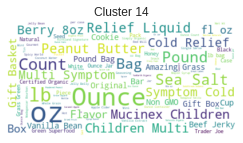

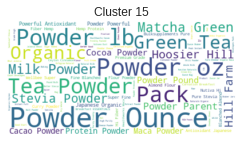

In [36]:
# Visualize the clusters
# Create wordclouds from clusters
from wordcloud import WordCloud

for k in range(true_k):
    start_time = time.time()
    text = title_cl[title_cl.cluster == k].title.str.cat(sep=' ')
    wordcloud = WordCloud(max_font_size=50, max_words=100, 
                          background_color='white').generate(text)
    
    # Create subplot
    plt.figure(figsize=(40, 40))
    plt.subplot(true_k, 2, k+1).set_title('Cluster ' + str(k))
    plt.plot()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('img/wordcloud_dec2013.png')
    end_time = time.time()
    
    save_pkl(end_time - start_time, 'wordcloud_runtime_dec2013.pkl')
plt.show()


- cluster0 - chocolate and coffee
- cluster1 - tea
- cluster2 - coconut and olive oil
- cluster3 - packs
- cluster4 - coffee brewing

### Count Vectorizer (unsucessful attempt)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_grams(docs, n=2):
    v = CountVectorizer(ngram_range=(n, n))
    grams = v.fit_transform(docs)
    gram_sum = np.array(np.sum(grams, axis=0)).flatten()
    gram_dict = {i: v for v, i in v.vocabulary_.items()}
    top_grams = gram_sum.argsort()[::1]
    
    return [gram_dict[i] for i in top_grams], gram_sum[top_grams]

In [39]:
doc = ' '.join(df_lemmatized_title_2013['product_title'])

In [40]:
doc[:100]

'chocolate river stones lb bag dave gourmet ultimate insanity hot sauce ounce class bottles pack krus'

In [55]:
ngrams, ngram_counts = {}, {}
for n in [1, 2, 3]:
    #ngrams[n], ngram_counts[n] = get_top_grams[lemmatized_text], n=n
    ngrams[n], ngram_counts[n] = get_top_grams([doc], n=n)

In [56]:
from scipy.stats import zipf
def make_zipf_plot(counts, tokens, a=1.15):
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    normalized_frequencies = counts[indices] / sum(counts)
    f = plt.figure(figsize=(8, 8))
    plt.loglog(ranks, normalized_frequencies, marker=".")
    
    plt.loglog(ranks, [z for z in zipf.pmf(ranks, a)])
    
    plt.title("Zipf Plot")
    plt.xlabel("Word frequency rank")
    plt.ylabel("Word frequency")
    
    ax = plt.gca()
    ax.set_aspect('equal') # make the plot square
    plt.grid(True)
    
    # add text labels
    last_freq = None
    labeled_word_idxs = list(np.logspace(-0.5,
                                         np.log10(len(counts) - 1),
                                         10).astype(int))
    for i in labeled_word_idxs:
        dummy = plt.text(ranks[i],
                         normalized_frequencies[i],
                         " " + tokens[indices[i]],
                         verticalalignment="bottom",
                         horizontalalignment="left")
    plt.show()

In [59]:
ngram_counts

{1: array([    1,     1,     1, ...,  8498,  9914, 12070]),
 2: array([   1,    1,    1, ..., 1326, 1423, 2035]),
 3: array([   1,    1,    1, ...,  547,  592, 1130])}

In [10]:
# make_zipf_plot(ngram_counts, ngrams)

## Hierarchical Clustering (impractical due to large no. of data points)

In [ ]:
# dense_2013 = d_matrix_2013.to_dense()

In [ ]:
# aggloclustering

#sum_of_squared_distances = []
#K = range(2, 20)

#for k in K:
#    aglo = fastcluster.ward(n_clusters=k, max_iter=600, n_init=10)
#    km.fit(d_matrix_2013)
#    sum_of_squared_distances.append(km.inertia_)

### Finding `k` Using `kelbow_visualizer`

Ward's Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2013,
                        k=(2, 20),
                        linkage='ward',
                        show=False)

Complete Linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2013,
                        k=(2, 20),
                        linkage='complete',
                        show=False)

Average Method

In [ ]:
try:
    viz = kelbow_visualizer(AgglomerativeClustering(),
                            dense_2013,
                            k=(2, 20),
                            linkage='average',
                            show=False)
except MemoryError():
    sys.exit()
    

Single-linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2013,
                        k=(2, 20),
                        linkage='single',
                        show=False)

Function for the hierarchical clustering visualizer

In [ ]:
def viz_agglo_elbow(data, linkage='single', k=(2, 20)):
    """
    Find the score elbow for agglomerative clustering using the 
    `kelbow_visualizer` library and generate corresponding elbow plot. 
    """
    viz = kelbow_visualizer(AgglomerativeClustering(), 
                            data, k,linkage=linkage, show=False)
    return viz

### Finding `k` using dendrograms

Ward's Method (interrupted... too long to run)

In [ ]:
dendrogram(fastcluster.linkage(d_matrix_2013, method='ward'), 
           truncate_mode='lastp', 
           #method='ward', 
           p=5,
           optimal_order=False
          )
plt.xlabel('points in cluster')
plt.ylabel('depth')

Complete Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2013), truncate_mode='lastp', 
            method='complete', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Average Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2013), truncate_mode='level', 
            method='average', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Single-linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2013), truncate_mode='level', 
            method='single', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

The best `k` value found was xx using yy method.

### Scatterplot using the best `k` found

In [ ]:
best_k_ac = 6

In [ ]:
ac = AgglomerativeClustering(n_clusters=best_k_ac)
ac.fit(d_matrix_2013.to_numpy())

In [ ]:
scatter2 = plt.scatter(tsvd_2013_n[:, 0],
                       tsvd_2013_n[:, 1],
                       c=ac.labels_,
                       cmap='Dark2')
plt.legend(*scatter2.legend_elements())
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
plt.title(f'Clusters Found Using Agglomerative Methods, best k={best_k_ac}')
plt.show();

## Density-based Clustering

### DBSCAN

In [ ]:
try:
    core_points = d_matrix_2013.shape[1] * 2
    nn = NearestNeighbors(n_neighbors=core_points + 1)
    nn = nn.fit(d_matrix_2013)
    distances, neighbors = nn.kneighbors(d_matrix_2013)
    average_distances = distances[:, 1:].mean(axis=1)
    average_distances = np.sort(average_distances)
    
    plt.plot(average_distances)
    plt.xlabel('point number')
    plt.ylabel(f'average distance to {core_points} neighbors')
    plt.show();
    
except MemoryError():
    sys.exit()

In [ ]:

kneedle = KneeLocator(range(average_distances.shape[0]),
                      average_distances,
                      curve="concave",
                      direction="increasing")

kneedle.plot_knee()
plt.xlabel('point number')
plt.ylabel(f'average distance to {core_points} neighbors')
plt.show();

eps = average_distances[kneedle.knee]


In [ ]:
print(f'epsilon: {eps}, point no.: {kneedle.knee}')

In [ ]:
try:
    
    db = DBSCAN(eps=eps, min_samples=d_matrix_2013.shape[1]*2, n_jobs=-1)
    db.fit(d_matrix_2013)
    
except MemoryError():
    sys.exit()

In [ ]:
try:

    cluster_labels = db.fit_predict(tsvd_2013_n)
    scatter3 = plt.scatter(tsvd_2013_n[:, 0], 
                           tsvd_2013_n[:, 1], 
                           c=cluster_labels, 
                           cmap='Dark2', s=40)
    plt.legend(*scatter3.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    plt.title(f'Clusters Found Using DBSCAN, k={cluster_labels.max()+1}')

    print('Number of clusters:', cluster_labels.max()+1)
    print('Number of noise points:', (cluster_labels==-1).sum())
    print('Number of points:', len(cluster_labels))
    
except MemoryError():
    sys.exit()
